<a href="https://colab.research.google.com/github/teodoragrubor/projekatPPPO/blob/master/SegmentacijaMedicinskeSlike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projektni zadatak: Segmentacija slike** 

**Segmentacija medicinskih** slika ima veoma veliku ulogu u medicini što omogućava primenu različitih algoritama na snimke kao što su mikroskopija, rendgen, ultrazvuk, magnetna rezonansa i slično. Na ovaj način, slike se dele u odgovarajuće piksele tj. dele se na osnovu određenog područja ili kategorije što znatno pomaže medicinskom osoblju u bržem, boljem i kvalitetnijem otkrivanju anomalija na pomenutim snimcima. S obzriom da su medicinske fotografije veoma promenljive prirode i da predstavljaju individualno stanje svakog pojedinca, kreiranje algoritama za segmentaciju ovakvih slika veoma je kompleksan zadatak.

Set podataka koji je dobijen za izradu ovog projektnog zadatka odnosi se na fotografije ***ultrazvuka nerava ljudskog tela***. Ultrazvučne slike pomažu u otkrivanju bolova, oticanja i infekcija u ljudskim organima. Znatno su jeftinije nego slike CT-a i magnetne rezonanse. 

Za treniranje modela postoje različite metode i arhitekture a neke od njih su: potpuno konvolucione neuronske mreže, neuronske mreže enkodera-dekodera, periodične neuronske mreže, generativne kontradiktorne mreže itd...

Glavnu ulogu u segmentaciji slike ima ***set podataka*** kojim se manipuliše. Potrebno je razumevanje i poznavanje seta podataka kako bi se razumelo na koji način je najbolje raditi sa njim. U ovom slučaju, set podataka je podeljen na dva glavna foldera i to su **train** i **test**. 

**U train** folderu nalaze se fotografije koje u svom nazivu sadrže ili ne sadrže "**mask**". Fotografije koje ne sadrže mask u sebi, predstavljaju fotografije koje se ubacuju u odredjeni algoritam i na osnovu kojih algoritam vrši predikciju. Sa druge strane, "mask" fotografije podrazumevaju ono šta algoritam treba da izbaci. U velikom broju slučajeva, algoritam ne izbacuje masku kao što je očekivana jer to zavisi od istreniranosti modela koji se koristi i primenjuje na set podataka. Na osnovu razlike slike ultrazvuka nerava i njegove odgovarajuće maske, računa se greška.

**Test folder** je folder slika koji nam služi za testiranje, tačnije, on se ne trenira. Na kraju, kada dodjemo do određene preciznosti treniranja, proveravaju se rezultati i generišu se zaključci koji se odnose na rezultate algoritma. 



***PRILOŽEN KOD***


Početak ovog projekta, rezervisan je za instaliranje odgovarajućih biblioteka koje su neophodne za njegovu realizaciju. Prva biblioteka (*segmentation_models_pytorch albumentations*) zasnovana je na PyTorch-u. To je biblioteka koja se koristi za deep learning aplikacije koje koriste GPU ili CPU. Pored ove biblioteke, neke od poznatijih su Tensorflow i Keras. Takođe, kao što je pomenuto, hardware acceleration za izradu ovog projektnog zadatka podešen je na GPU. Hardversko ubrzanje predstavlja proces kojim će aplikacija rasteretiri određene računarske zadatke na specijalizovane hardverske komponente u sistemu i na taj način će se omogućiti veća efikasnost nego što je to moguće u softveru koji radi samo na CPU opšte namene. 

***GPU - Graphics Processing Units ***(Jedinice za orbadu grafike) koriste se za proračune koji uključuju velike količine podataka. 

Sledeća instalacija odnosi se na instalaciju ***albumentations*** biblioteke. To je Python biblioteka za povećavanje kvaliteta obučenih modela. Svrha povećanja slike je stvaranje novih uzoraka obuke postojećih podataka. Ova biblioteka pruža jednostavan rad sa svim tipovima podataka kao što su RBG slike, slike u sivim tonovima, maske za segmentaciju, okviri za ograničavanje i ključne tačke.


In [14]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5oq4rcsg
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5oq4rcsg
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=65114c442a8db36b665aba3f5f3ba04b5a0665d1214d2b22873b9521e77ef53e
  Stored in directory: /tmp/pip-ephem-wheel-cache-r24nwp67/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


Drugi korak je importovanje. Prilikom importovanja obavljaju se dve operacije, traži se odgovarajući modul a zatim se rezultati pretrage tog modula vezuju za odredjene opsege.

In [15]:
import os 
import csv 
import re 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import itertools 
import cv2
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold
import shutil
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import albumentations
import torchvision 
from torchvision import transforms, models
import random
import segmentation_models_pytorch as smp
from PIL import Image

Definisanje ruta gde se nalaze podaci. U ovom koraku, definišemo glavnu rutu sa folderima i to je ruta koja vodi do foldera na MyDrive-u gde se nalaze podaci. Ruta trainpath odnosi se na rutu za train folder, koji služi za treniranje kako je već ranije i napomenuto, dok ruta testpath se odnosi na folder za testiranje podataka. 

In [16]:
ruta = "/content/drive/MyDrive/#8"
trainpath = "/content/drive/MyDrive/#8/train" 
testpath = "/content/drive/MyDrive/#8/test"

masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]

df = pd.DataFrame({"image":imgs,"mask":masks})

df_train, df_val = train_test_split(df,test_size = 0.15)



Nakon što smo povezali rute, učitavamo nekoliko fotografije iz dataseta na nasumičan način putem importovane funkcije random i fotografije ce biti prikazene u tri reda i tri kolone. 

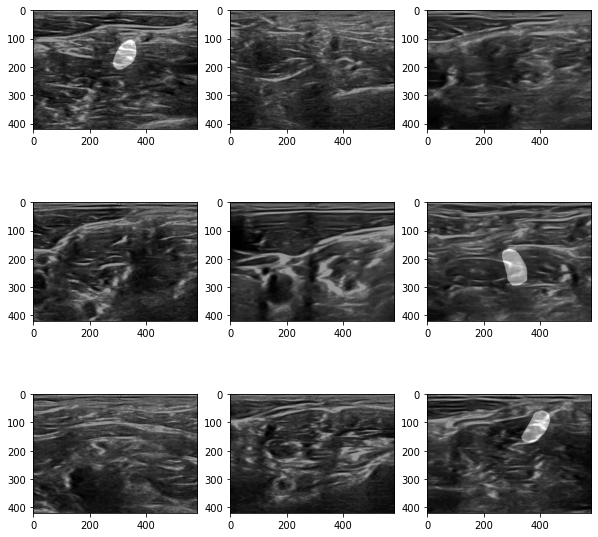

In [17]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10)) 
for i in range(1,rows*cols+1): 
    ii = random.randint(0, len(df)) 
    fig.add_subplot(rows,cols,i) 
    img_path=df['image'][ii]
    msk_path=df['mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray') 
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray') 
plt.show() 

Podesavanje odredjenih parametara za testiranje i kreiranje klase DataSet

In [6]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor))
    return albumentations.Compose(transform)


def trainaugs():
    transform =  [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
                albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0),
                albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2), 
                albumentations.HorizontalFlip(), 
            ]
    return albumentations.Compose(transform) 

def valaugs():
    transform = [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
            ]
    return albumentations.Compose(transform)

class GetDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None,preprocess=None): 
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
    
    def __getitem__(self,idx):
        image = cv2.cvtColor(cv2.imread(self.imagespath[idx]),cv2.COLOR_BGR2RGB) 
        mask = cv2.imread(self.maskspath[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment:
            sample = self.augment(image=image, mask=mask) 
            image,mask = sample['image'],sample['mask']
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']

        mask = (mask / 255).astype(np.float32) 
        mask = np.expand_dims(mask, axis=0) 

        return image,mask

***MODEL*** - deo koji se čuva nakon pokretanja algoritma mašinskog učenja nad podacima za obučavanje i predstavlja određena pravila koja su neophodna algoritmu za predviđanja. Reprezentuje kako da odredjene inpute pretvorimo u outpute

In [7]:
encoder = "resnet34" 
encoder_wts = "imagenet" 
activation = "sigmoid" 


model = smp.Unet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts)
preprocess_func = smp.encoders.get_preprocessing_fn(encoder,encoder_wts)


traindata = GetDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(), 
                            preprocess = func_for_preprocessing(preprocess_func)) 
validationdata = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))

batch_size = 6 
trainloader = DataLoader(traindata,batch_size = batch_size,shuffle=True) 
valloader = DataLoader(validationdata,batch_size=batch_size,shuffle=False) 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


***TRENIRANJE MODELA*** - u grubom prevodu znači da utvrdimo dobre i prave vrednosti za sve tezine iz oboleženih i priloženih primera tj. dataset-a. Na ovaj način, model se gradi ispitivanjem različitih primera i pokušajem pronalska modela koji minimizira gubitak, 

In [9]:
trainmodel = True
epochs = 5
device = "cuda"
loss = smp.utils.losses.DiceLoss() 
metrics = [ smp.utils.metrics.IoU(threshold=0.5) ]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device=device,verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device=device,verbose=True)

Treniranje 

In [10]:
best_iou_score = 0.0 
train_logs_list, valid_logs_list = [], []
for i in range(0,epochs):
    print('\nEpoch: {}'.format(i))
    trainlogs = trainepoch.run(trainloader)
    validlogs = validepoch.run(valloader)
    lr_scheduler.step()

    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)
    if best_iou_score < validlogs['iou_score']:
        best_iou_score = validlogs['iou_score'] 
        torch.save(model, './best_model.pth') 


Epoch: 0
train:  47%|████▋     | 375/800 [25:51<29:18,  4.14s/it, dice_loss - 0.6684, iou_score - 0.2252]


error: ignored

Graficki prikaz dobijenih rezultata. Prvi grafik prikazuje Presek preko unije odnosno prikazuje kolicinu preklapanja izmedju predvidjenog i osnovnog okvira. Sto je blizi 1 to je preklapanje vece. Drugi grafik prikazuje odstupanja, tj prethodno pomenuti Dice Loss. Na osama se nalazi broj epoha iz gore prilozenog koda

In [12]:
plt.figure(figsize=(10,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(),'g-',lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(),'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(),'g-',lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(),'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

NameError: ignored

<Figure size 720x288 with 0 Axes>

Testiranje najboljeg modela, koji je po prethodnom kodu sacuvan na putanji *best_model.pth*

In [13]:
best_model = torch.load('./best_model.pth')

test_dataset = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))


test_dataset_vis = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist())


def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[0] == 3:
            image = image.transpose([1, 2, 0])
        plt.imshow(image)
    plt.show()

for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
   
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()

    pr_mask = cv2.resize(pr_mask, (580, 420))
    
    visualize(
        image=image_vis, 
        predicted_mask=pr_mask,
       
    )

FileNotFoundError: ignored

Evaluacija testiranja - rezultata. Provera objekata za testiranje prolaskom kroz sve objekte.

In [ ]:
imgs = [f for f in os.listdir(testpath)]
imgs = sorted(imgs, key=lambda s: int(s.split('.')[0]))

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m))

    x = valaugs()(image=x)['image']
    x = func_for_preprocessing(preprocess_func)(image=x)['image']

    x_tensor = torch.from_numpy(x).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = albumentations.Resize(height=420,width=580,interpolation=Image.NEAREST)(image=pr_mask)['image']

    encodings.append(rle_encoding(pr_mask))